In [1]:
from Learning import *
from Graphing import *

In [1]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d1,2,4,8,20_all_61k") # Load combo

In [ ]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

Data normalization/feature scaling

In [ ]:
print(Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales = scale_data(X, X_labels)
Yr_scales = scale_data(Yr, Yr_labels)
Yr.max(), X.max()

Remove match duration feature(s) (win prediction use case)

In [ ]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
X.shape

Define experiment models & variables

In [6]:
model_strs = ["LogisticRegression", "MLPClassifier", "RandomForestClassifier", "LinearSVC"]
y_label = "blue_win"
n_repeat_runs = 5  # Number of repeat runs to get average over
n_tier_test = 500  # Number of samples to test for each tier in each run
n_buckets = 10     # Number of percentile buckets to use for histogram
n_train = 10000    # Number of datapoints to use

Y = Yc[:, Yc_labels.index(y_label)].reshape(-1, 1)
X.shape, Y.shape

((18390, 5632), (18390, 1))

Identifying testing sample indices for each tier/elo range

In [7]:
elo_meta_i = meta_labels.index("elo")
tiered_data_is = [
    ("bronze", np.nonzero(meta[:, elo_meta_i] <= 500)[0]),
    ("silver", np.nonzero(np.logical_and(meta[:, elo_meta_i] > 500, meta[:, elo_meta_i] <= 1000))[0]),
    ("gold", np.nonzero(np.logical_and(meta[:, elo_meta_i] > 1000, meta[:, elo_meta_i] <= 1500))[0]),
    ("platinum", np.nonzero(np.logical_and(meta[:, elo_meta_i] > 1500, meta[:, elo_meta_i] <= 2000))[0]),
    ("diamond", np.nonzero(np.logical_and(meta[:, elo_meta_i] > 2000, meta[:, elo_meta_i] <= 2500))[0]),
    ("master+ (>2500 Elo rating)", np.nonzero(meta[:, elo_meta_i] > 2500)[0]),
]
n_tiers, n_models = len(tiered_data_is), len(model_strs)
arglist = sum([sum([[(mkey, tier_inds) for _ in range(n_repeat_runs)] \
          for __, tier_inds in tiered_data_is], []) for mkey in model_strs], [])
len(arglist)

120

Train & test models

In [8]:
results = Parallel(n_jobs=n_parallel_cpu, verbose=12)(delayed(test_model_prob)(
    mkey, X, Y, tier_inds, n_train, n_tier_test) for mkey, tier_inds in arglist)
len(results), results[0].shape

[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   50.3s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   50.4s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:   53.9s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:   55.8s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:   57.8s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Do

(120, (500,))

Generate histogram data

In [9]:
res = np.asarray([[[results[i + (j * n_repeat_runs) + (k * n_repeat_runs * n_models)] \
      for i in range(n_repeat_runs)] for j in range(n_tiers)] for k in range(n_models)]) * 100
res.shape # Shape of res: (n_models, n_tiers, n_repeat_runs, n_tier_test)

(4, 6, 5, 500)

Plot histograms

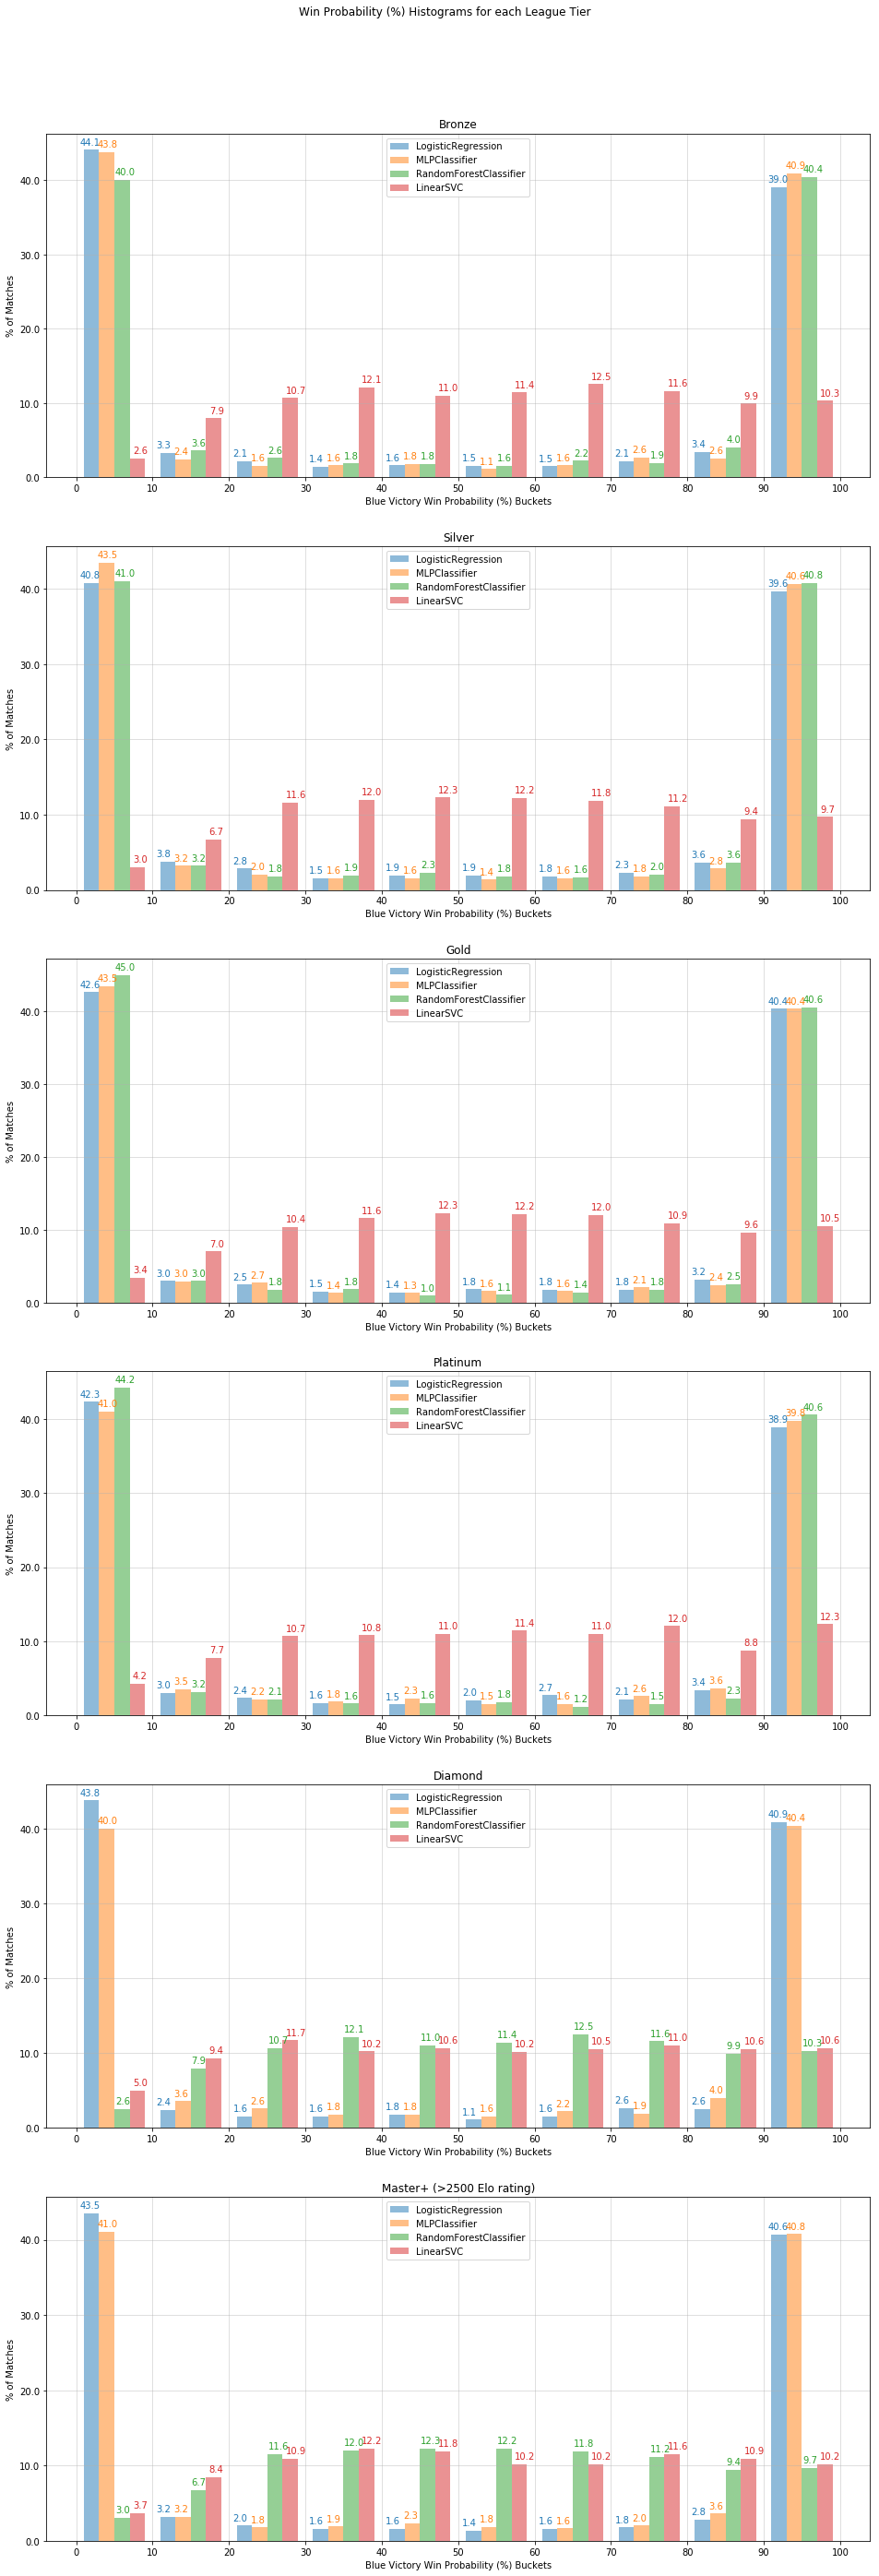

In [16]:
def to_percent(y, position):
    return str(y * 100 * (100/n_buckets))
fig = plt.gcf()
plt.suptitle("Win Probability (%) Histograms for each League Tier", y=0.92)
fig.set_size_inches(16, 8 * n_tiers)
m = 1
for i in range(n_tiers):
    ax = plt.subplot(n_tiers, 1, m)
    ax.set_title(tiered_data_is[i][0][0].upper() + tiered_data_is[i][0][1:])
    plt.ylabel("% of Matches")
    plt.xlabel("Blue Victory Win Probability (%) Buckets")
    ax.set_xticks(np.arange(0, 101, 10))
    ax.grid(alpha=0.5)
    counts, bins, ps = plt.hist([np.hstack(res[j, i]) for j in range(n_models)], n_buckets, alpha=0.5,
             label=[model_strs[j] for j in range(n_models)], normed=True)
    if n_models == 1:
        counts, ps = [counts], [ps]
    counts_sum = sum(sum(counts)) / n_models
    for j in range(n_models):
        cnts = counts[j]
        col = ps[j][0].get_fc()
        for k in range(n_buckets):
            ax.text(bins[k] + 0.5 + (j * 2.3), cnts[k] + 0.0007,
                    str(round((cnts[k] / counts_sum) * 100, 1)), color=col, alpha=1.0)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(loc='upper center')
    m += 1
plt.savefig(graphs_folder + "win_probability_histogram" + '.pdf', format='pdf')
plt.show()

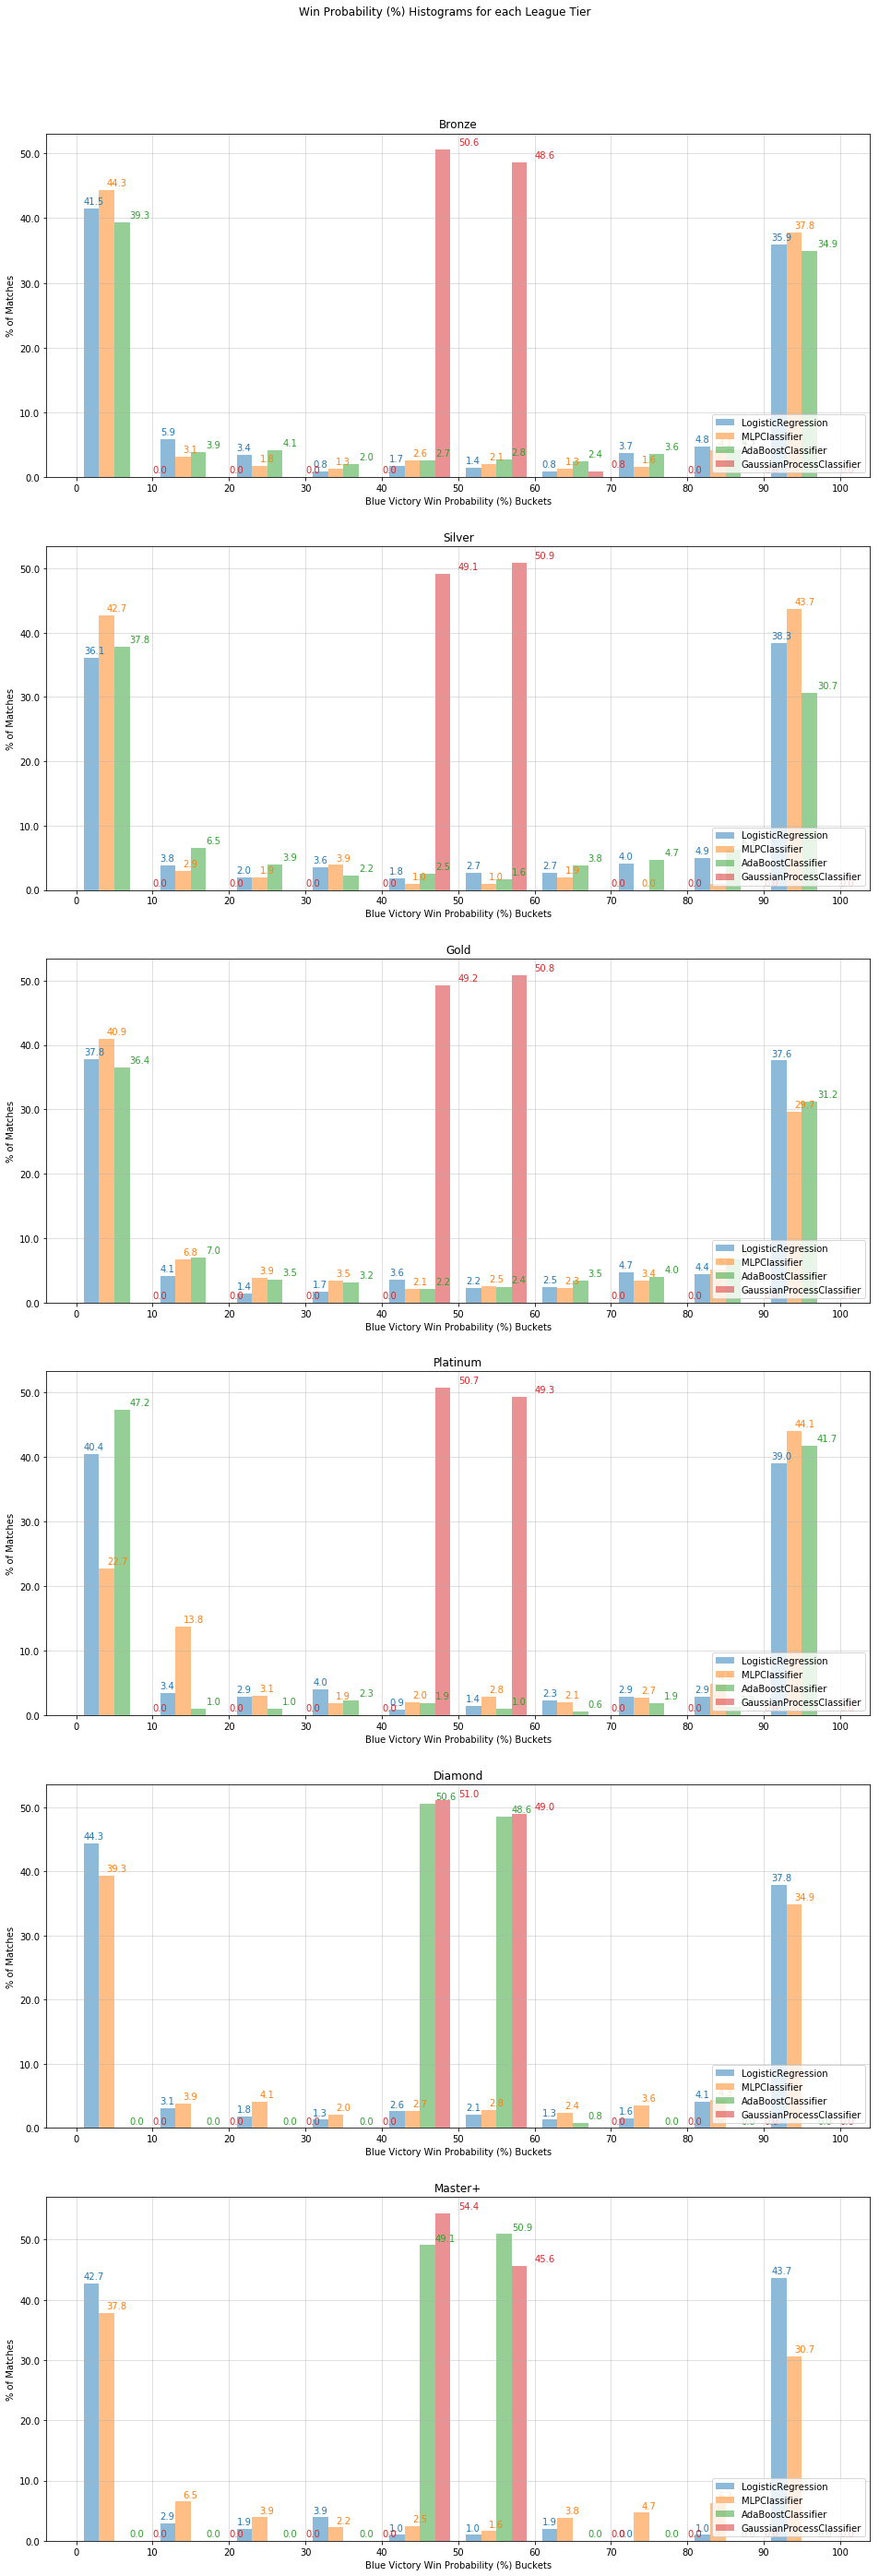

In [18]:
def to_percent(y, position):
    return str(n_buckets * 100 * y)
fig = plt.gcf()
plt.suptitle("Win Probability (%) Histograms for each League Tier", y=0.92)
fig.set_size_inches(16, 8 * n_tiers)
m = 1
for i in range(n_tiers):
    ax = plt.subplot(n_tiers, 1, m)
    ax.set_title(tiered_data_is[i][0][0].upper() + tiered_data_is[i][0][1:])
    plt.ylabel("% of Matches")
    plt.xlabel("Blue Victory Probability (%) Buckets")
    ax.set_xticks(np.arange(0, 101, 10))
    ax.grid(alpha=0.5)
    counts, bins, ps = plt.hist([np.hstack(res[j, i]) for j in range(n_models)], n_buckets, alpha=0.5,
             label=[model_strs[j] for j in range(n_models)], normed=True)
    for j in range(n_models):
        cnts = counts[j]
        col = ps[j][0].get_fc()
        for k in range(n_buckets):
            ax.text(bins[k] + 1.0 + (j * 3), cnts[k] + 0.0007,
                    str(round(cnts[k] * n_buckets * 100, 1)), color=col, alpha=1.0)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(loc='lower right')
    m += 1
plt.show()